# Exploratory data analysis

This notebook provides an exploratory data analysis of the dataset. As a reminder, this dataset  - `Description des emplois salariés en 2021` is taken from the `Insee` website at the following link : <https://www.insee.fr/fr/statistiques/7651654#dictionnaire>.
We aim to study the effect of gender on the level of wages, depending on several variables. This code provides a first glance at the structure of our data.

In [41]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon
from tqdm import tqdm
import gdown
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected= True)
import plotly.express as px
import seaborn as sns

`Warning` : This code should be run after the [import and formating notebook](test_import_données.ipynb).

In [42]:
base = pd.read_csv("INSEE_DATA_TREATED.csv", delimiter=",")

C:\Users\grnma\AppData\Local\Temp\ipykernel_8576\3172684118.py:1: DtypeWarning:

Columns (1,2,4,25,32,33) have mixed types. Specify dtype option on import or set low_memory=False.



In [43]:
base.head()

,Unnamed: 0,A6,A17,A38,CPFD,DATDEB,DATFIN,DEPR,DEPT,DOMEMPL,...,DOMEMPL_EM_N,DOMEMPL_N,REGR_N,REGT_N,CS_N,DEPR_N,DEPT_N,WAGE,UNEMP,A38_N
0,0,BE,C5,CG,C,1.0,360.0,49,49,9.0,...,Autres sociétés privées,Autres sociétés privées,Pays de la Loire,Pays de la Loire,Ouvriers non qualifiés de type industriel,Maine-et-Loire,Maine-et-Loire,20000,NaN,Fabrication de produits en caoutchouc et en pl...
1,1,BE,C5,CG,C,31.0,360.0,53,35,9.0,...,Autres sociétés privées,Autres sociétés privées,Pays de la Loire,Bretagne,Ouvriers non qualifiés de type industriel,Mayenne,Ille-et-Vilaine,14000,NaN,Fabrication de produits en caoutchouc et en pl...
2,2,BE,C5,CG,C,1.0,360.0,59,59,9.0,...,Autres sociétés privées,Autres sociétés privées,Nord – Pas-de-Calais – Picardie,Nord – Pas-de-Calais – Picardie,Ingénieurs et cadres techniques d'entreprises,Nord,Nord,30000,NaN,Fabrication de produits en caoutchouc et en pl...
3,3,BE,C5,CG,C,288.0,360.0,62,62,9.0,...,Autres sociétés privées,Autres sociétés privées,Nord – Pas-de-Calais – Picardie,Nord – Pas-de-Calais – Picardie,Ouvriers non qualifiés de type industriel,Pas-de-Calais,Pas-de-Calais,3000,NaN,Fabrication de produits en caoutchouc et en pl...
4,4,BE,C5,CG,C,1.0,360.0,66,66,9.0,...,Autres sociétés privées,Autres sociétés privées,Languedoc-Roussillon – Midi-Pyrénées,Languedoc-Roussillon – Midi-Pyrénées,Ouvriers qualifiés de type industriel,Pyrénées-Orientales,Pyrénées-Orientales,20000,NaN,Fabrication de produits en caoutchouc et en pl...


In [44]:
base.columns

Index(['Unnamed: 0', 'A6', 'A17', 'A38', 'CPFD', 'DATDEB', 'DATFIN', 'DEPR',
       'DEPT', 'DOMEMPL', 'DOMEMPL_EM', 'DUREE', 'FILT', 'REGR', 'REGT',
       'SEXE', 'PCS', 'TYP_EMPLOI', 'CONV_COLL', 'NBHEUR', 'NBHEUR_TOT', 'AGE',
       'TRNNETO', 'TRALCHT', 'TREFF', 'CONT_TRAV', 'CS', 'AGE_TR', 'DATDEB_TR',
       'DATFIN_TR', 'DUREE_TR', 'POND', 'DOMEMPL_EM_N', 'DOMEMPL_N', 'REGR_N',
       'REGT_N', 'CS_N', 'DEPR_N', 'DEPT_N', 'WAGE', 'UNEMP', 'A38_N'],
      dtype='object')

Further explanations on the meaning of the variables and their type :

In [45]:
numerical_columns = [
    'DATDEB', 'DATFIN', #date début et fin de rémunération par rapport au 01/01
     'AGE', #age en années
     'POND', #pondération 1/12e
    'DUREE', #durée de paie en jours
      'NBHEUR', 'NBHEUR_TOT', #nombre d'heures salariées total (quelle diff?)
    'WAGE', #transformation of TRNNETO
    'UNEMP' #transformation of TRALCHT
]
categorical_columns = [
    'A6', 'A17', 'A38' #activité en nomenclature agrégrée
    'CPFD', #temps complet ou partiel
    'DEPR', 'DEPT', #département résidence et travail
    'DOMEMPL', 'DOMEMPL_EM', #domaine de l'emploi et l'établissement d'affectation/employeur
    
    'FILT', #indic poste annexe 2 ou non-annexe 1 (seuils rémunération volume)
    'REGR', 'REGT', #région de résidence et de travail
    'SEXE', #1 homme 2 femme
    'PCS', #PCS-ESE
    'TYP_EMPLOI', #ordinaire, apprenti, autre
    'CONV_COLL', #convention collective
  
    'TRNNETO', #rémunération nette globale en tranches -> à passer en numérique ?
    'TRALCHT', #total des indémnités de chômage, en tranches -> passage en numérique ?
    'TREFF', #tranche d'effectif : de 0 à 250+ postes
    'CONT_TRAV', #contrat de travail : APP apprentissage, TOA occasionnel ou à l'acte, TTP intérim, AUTre
    'CS', #CSP mais code plus simple 
    'AGE_TR', #age en tranches quadriennales
    'DATDEB_TR',
       'DATFIN_TR', #dates début et fin rémunération en tranches
    'DUREE_TR', #durée de paie exprimée en jours en tranches mensuelles
    'DOMEMPL_EM_N', 'DOMEMPL_N', 'REGR_N',
       'REGT_N', 'CS_N', 'DEPR_N', 'DEPT_N','A38_N' #les variables renommées avec les labels correspondants aux codes
]
all_columns = numerical_columns + categorical_columns

In [46]:
#The dataset is very large :
print(f"Number of rows : {base.shape[0]}, number of columns : {base.shape[1]}")

Number of rows : 2403775, number of columns : 42


### Descriptive analysis

Our target variable is the wage of our individuals. In the dataset, wage is coded as a categorical variable.

In [47]:
#WAGE has been preprocessed. We chose to keep the lower bound of the each wage range.

base['WAGE'].sort_values().unique()

array([    0,   200,   500,  1000,  1500,  2000,  3000,  4000,  6000,
        8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000, 24000,
       26000, 28000, 30000, 35000, 40000, 50000])

Text(0.5, 1.0, 'Distribution of the "WAGE" variable')

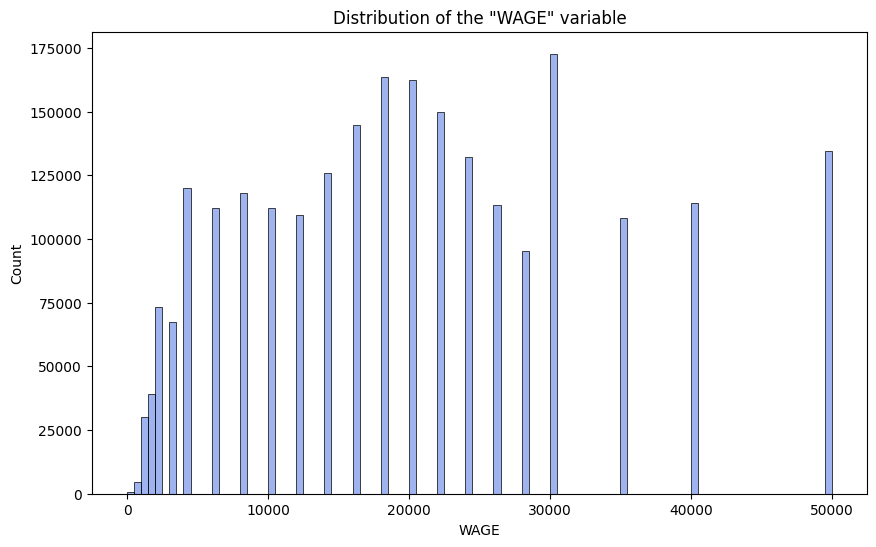

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(base['WAGE'], bins=100, color = 'royalblue', alpha = 0.5)
plt.title('Distribution of the "WAGE" variable')

Such histogramms can be plotted with other variables

Text(0.5, 1.0, 'Distribution of the age')

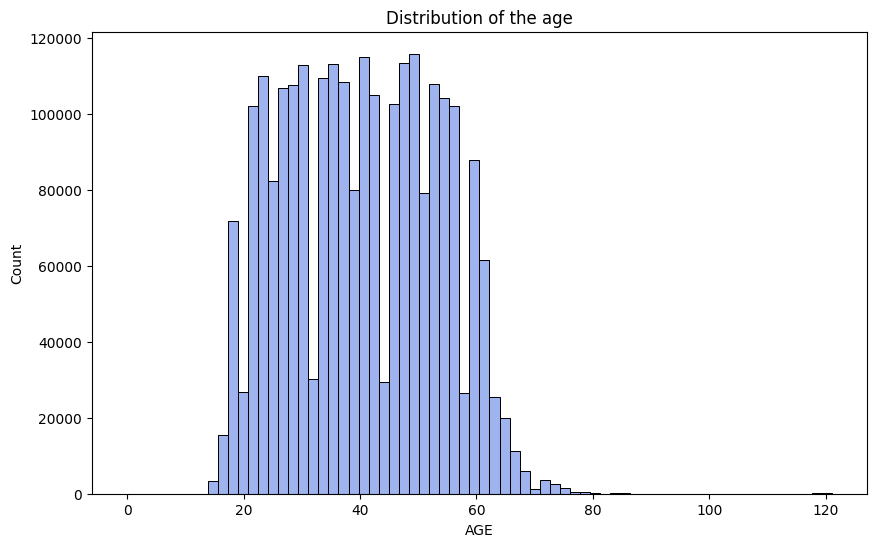

In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(base['AGE'], bins=70, color = 'royalblue', alpha = 0.5)
plt.title('Distribution of the age')

Text(0.5, 1.0, "Distribution of 'AGE_TR' : age in slices of 4 years")

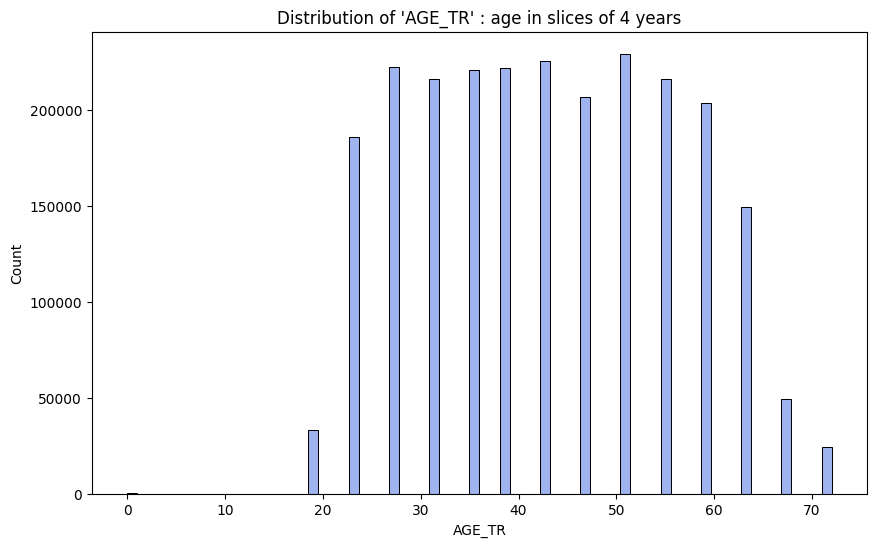

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(base['AGE_TR'], bins=70, color = 'royalblue', alpha = 0.5)
plt.title("Distribution of 'AGE_TR' : age in slices of 4 years")

One can also better grasp the fluctuations on the labor market, usign the 'DATDEB' and 'DATFIN' columns which give the start and end dates of the employment period. 'DUREE' might also be useful in that case.

In [51]:
print(f"Proportion of individuals with DUREE = 360 days : {round(base[base['DUREE'] == 360].shape[0] / base.shape[0], 3)}")

Proportion of individuals with DUREE = 360 days : 0.6


In [52]:
#Print the proportion of individuals with DATDEB = 1 and DATFIN = 365
print(f"Proportion of individuals with DATDEB = 1 and DATFIN = 360 : {round(base[(base['DATDEB'] == 1) & (base['DATFIN'] == 360)].shape[0] / base.shape[0], 3)}")

Proportion of individuals with DATDEB = 1 and DATFIN = 360 : 0.619


In [53]:
print(f"Average duration between DATDEB and DATFIN for individuals with |DATDEB - DATFIN| != 360 : {round(base[base['DATDEB'] != 1]['DATFIN'].mean(), 2)}")

Average duration between DATDEB and DATFIN for individuals with |DATDEB - DATFIN| != 360 : 320.5


We are interested in the link between the wage level and the gender of any given individual, controlling on the other variables we have available. First, one can see that gender has a great influence over the average wage level and on the field of work.

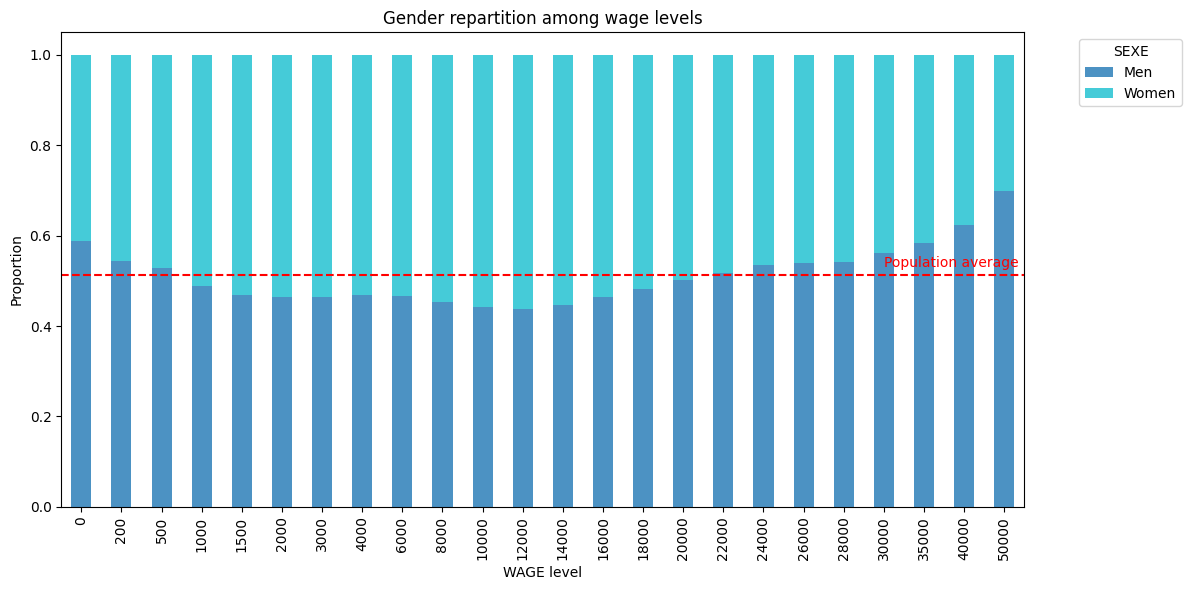

In [54]:
#Plot the stacked barplot of 'WAGE' levels depending on 'SEXE'
wage_sexe_counts = base.groupby(['WAGE', 'SEXE']).size().unstack(fill_value=0)
wage_sexe_proportions = wage_sexe_counts.div(wage_sexe_counts.sum(axis=1), axis=0)
wage_sexe_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10', alpha=0.8)

plt.title('Gender repartition among wage levels')
plt.xlabel('WAGE level')
plt.ylabel('Proportion')
legend_labels = ['Men', 'Women']  # Map 1 -> Men, 2 -> Women
plt.legend(title='SEXE', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0.512, color='red', linestyle='dashed')
plt.annotate('Population average', xy=(0, 0.512), xytext=(20, 0.53), color='red')

plt.tight_layout()

plt.show()

Women are over-represented in wages ranging from 1000€ to 22000€ net annual earnings. They account only for 30% of the highest earning category (>50 000€).

In [55]:
wage_sum_by_sexe = base.groupby('SEXE')['WAGE'].sum()
count_by_sexe = base.groupby('SEXE')['WAGE'].count()
average_wage_by_sexe = wage_sum_by_sexe / count_by_sexe
print("\nAverage wage per person by SEXE:")
print(average_wage_by_sexe)


Average wage per person by SEXE:
SEXE
1    21334.139711
2    18178.615886
Name: WAGE, dtype: float64


On average, women earn roughly 3000 € less than men in our dataset.
<br>

One can suppose that gap shall be explained by a difference in the hours worked between both gender groups.

In [56]:
from scipy.stats import ttest_ind

C:\Users\grnma\AppData\Local\Temp\ipykernel_8576\585221897.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\grnma\AppData\Local\Temp\ipykernel_8576\585221897.py:7: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



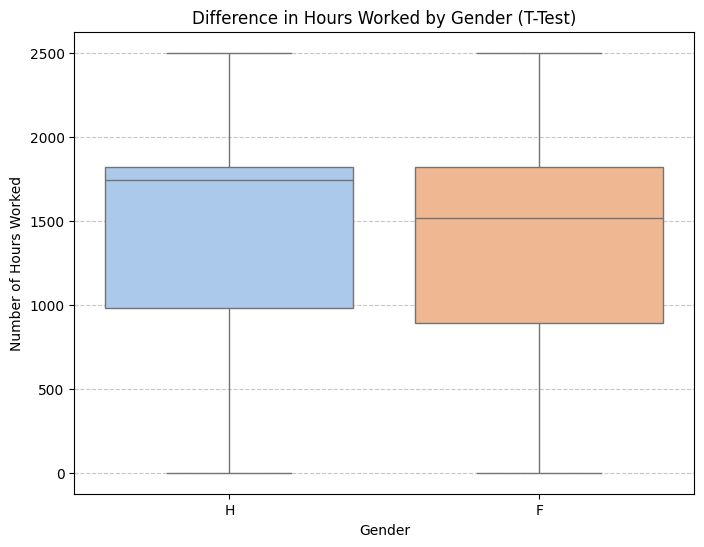

In [106]:
men_hours = base[base['SEXE'] == 1]['NBHEUR'].dropna()
women_hours = base[base['SEXE'] == 2]['NBHEUR'].dropna()

t_stat, p_value = ttest_ind(men_hours, women_hours, equal_var=False)  # Welch’s t-test (does not assume equal variance)

plt.figure(figsize=(8, 6))
sns.boxplot(x='SEXE', y='NBHEUR', data=base, palette=sns.color_palette("pastel"), showfliers=False)

# Labels and title
plt.title("Difference in Hours Worked by Gender (T-Test)")
plt.xlabel("Gender")
plt.ylabel("Number of Hours Worked")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(ticks=[0, 1], labels=["H", "F"]) 


# Show the plot
plt.show()

C:\Users\grnma\AppData\Local\Temp\ipykernel_8576\51467237.py:7: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



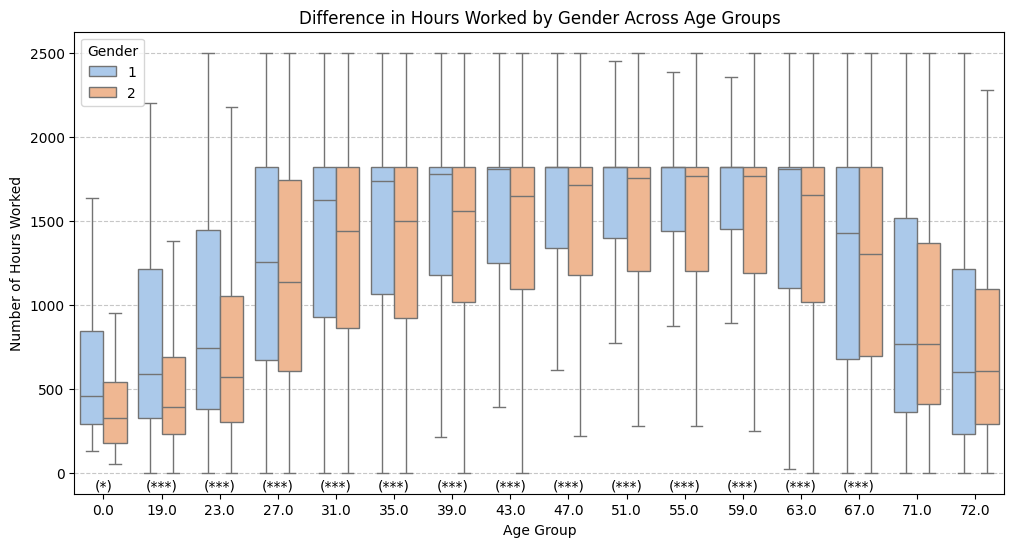

In [109]:
age_groups = sorted(base['AGE_TR'].dropna().unique())
age_labels = []  # To store age groups with significance stars


# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=base, x='AGE_TR', y='NBHEUR', hue='SEXE', 
            palette=sns.color_palette("pastel"), showfliers=False)

# Loop over each age group and calculate p-values
for i, age_group in enumerate(age_groups):
    group_data = base[base['AGE_TR'] == age_group]
    men_hours = group_data[group_data['SEXE'] == 1]['NBHEUR'].dropna()
    women_hours = group_data[group_data['SEXE'] == 2]['NBHEUR'].dropna()
    
    if len(men_hours) > 1 and len(women_hours) > 1:
        t_stat, p_value = ttest_ind(men_hours, women_hours, equal_var=False)

        # Convert p-value into significance stars
        if p_value < 0.001:
            p_text = "(***)"
        elif p_value < 0.01:
            p_text = "(**)"
        elif p_value < 0.05:
            p_text = "(*)"
        else:
            p_text = ""  # Not significant
    else:
        p_text = ""  # Not enough data

    # Display the significance levels
    if p_text:
        plt.text(i, -100, p_text, 
                 horizontalalignment='center', fontsize=10, color='black')



# Labels and title
plt.title("Difference in Hours Worked by Gender Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Number of Hours Worked")
plt.legend(title="Gender")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

As expected, the wealth difference between both gender groups is partly explained by the number of hours worked. Testing if the means are equal, the null hypothesis is rejected for almost every age group, apart for individuals aged 71 or more.

This point can also be made regarding the type of contracts proposed for each gender group, as displayed below.

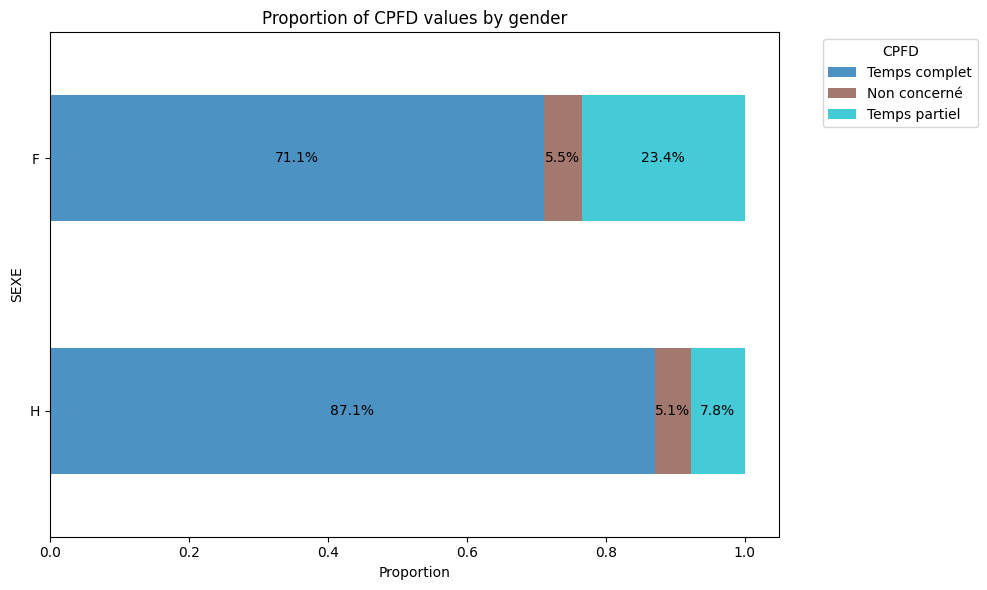

In [ ]:
# Group the data by AGE_GROUP and CPFD, and calculate the proportions
age_cpfd_counts = base.groupby(['SEXE', 'CPFD']).size().unstack(fill_value=0)
age_cpfd_proportions = age_cpfd_counts.div(age_cpfd_counts.sum(axis=1), axis=0)

# Plot the stacked bar plot
age_cpfd_proportions.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='tab10', alpha=0.8,)


# Add labels and title
custom_legend = ['Temps complet', 'Non concerné', 'Temps partiel']
plt.yticks(ticks=[0, 1], labels=["H", "F"]) 
plt.title('Proportion of CPFD values by gender')
plt.xlabel('Proportion')
plt.ylabel('SEXE')
plt.legend(title='CPFD', bbox_to_anchor=(1.05, 1), loc='upper left', labels = custom_legend)
for i, (row_name, row_data) in enumerate(age_cpfd_proportions.iterrows()):
    cumulative_sum = 0
    for j, (col_name, value) in enumerate(row_data.items()):
        # Calculate the position for text annotation (cumulative sum to stack it properly)
        cumulative_sum += value
        percentage = value * 100  # Convert to percentage
        if value > 0:  # Display only for non-zero values
            plt.text(cumulative_sum - value / 2, i, f'{percentage:.1f}%', 
                    horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

With further granulation :

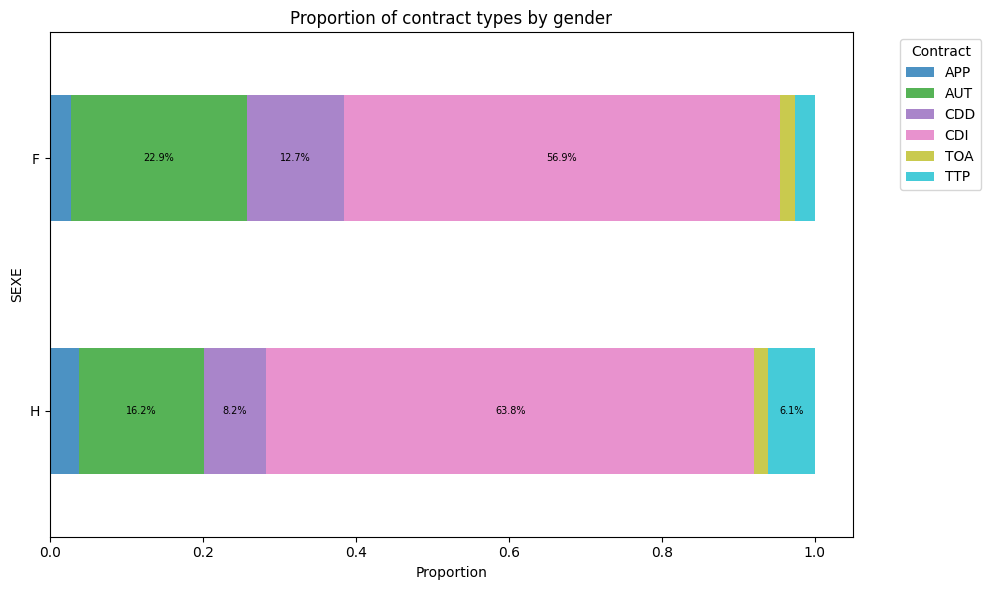

In [103]:
# Group the data by AGE_GROUP and CPFD, and calculate the proportions
age_cpfd_counts = base.groupby(['SEXE', 'CONT_TRAV']).size().unstack(fill_value=0)
age_cpfd_proportions = age_cpfd_counts.div(age_cpfd_counts.sum(axis=1), axis=0)

# Plot the stacked bar plot
age_cpfd_proportions.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='tab10', alpha=0.8,)


# Add labels and title
plt.yticks(ticks=[0, 1], labels=["H", "F"]) 
plt.title('Proportion of contract types by gender')
plt.xlabel('Proportion')
plt.ylabel('SEXE')
plt.legend(title='Contract', bbox_to_anchor=(1.05, 1), loc='upper left')
for i, (row_name, row_data) in enumerate(age_cpfd_proportions.iterrows()):
    cumulative_sum = 0
    for j, (col_name, value) in enumerate(row_data.items()):
        # Calculate the position for text annotation (cumulative sum to stack it properly)
        cumulative_sum += value
        percentage = value * 100  # Convert to percentage
        if value > 0.05:  # Display only for percentages > 5%
            plt.text(cumulative_sum - value / 2, i, f'{percentage:.1f}%', 
                    horizontalalignment='center', verticalalignment='center', fontsize=7, color='black')

plt.tight_layout()
plt.show()

Women are more enclined to work in a non-stable contract : they are more represented in the 'Autres' and 'CDD' types.

In [ ]:
categories = base['DOMEMPL_EM_N'].value_counts().index
counts = base['DOMEMPL_EM_N'].value_counts().values
fig, ax = plt.subplots()
ax.barh(categories, counts)
ax.set_xlabel("Domaine d'emploi")
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
categories = base['DOMEMPL'].value_counts().index
counts = base['DOMEMPL'].value_counts().values
fig, ax = plt.subplots()
ax.bar(categories, counts, width=0.5)
ax.set_xlabel("Domaine d'emploi")
ax.set_ylabel('Frequency')
plt.show()

## DAG : causal graph and choice of covariates

In [ ]:
import networkx as nx

from pgmpy.base.DAG import DAG

In [ ]:
#!pip install pgmpy

In [ ]:
digraph = nx.DiGraph(
    [
        ("AGE", "WAGE"),
        ("AGE", "SUBREGION"),
        ("AGE", "WHOURS"),
        ("AGE", "CSP"),
        ("AGE", "CONTRACT"),
        ("SEX", "WAGE"),
        ("SEX", "WHOURS"),
        ("SEX", "ACTIVITY 38"),
        ("SEX", "CSP"),
        ("SUBREGION", "WAGE"),
        ("SUBREGION", "NB EMPLOYEES"),
        ("CSP", "WAGE"),
        ("CSP", "CONV COLL"),
        ("CSP", "NB EMPLOYEES"),
        ("CSP", "WHOURS"),
        ("CONTRACT", "CSP"),
        ("CONTRACT", "WHOURS"),
        ("CONTRACT", "WAGE"),
        ("ACTIVITY 38", "CSP"),
        ("ACTIVITY 38", "WAGE"),
        ("ACTIVITY 38", "WHOURS"),
        ("ACTIVITY 38", "CONTRACT"),
        ("CONV COLL", "WAGE"),
    ]
)

In [ ]:
G = DAG(digraph)

In [ ]:
nx.draw_planar(G, with_labels=True)
plt.show()

In [ ]:
nx.draw(G, with_labels=True)
plt.draw()

In [ ]:
from pgmpy.utils import get_example_model
model = get_example_model("sachs")

# Plot the model
nx.draw(model)
plt.draw()

In [ ]:
#!pip install 'daft-pgm'

In [ ]:
from daft import PGM

In [ ]:
# Get a daft object.
model_daft = G.to_daft()
# To open the plot
model_daft.render()
# Save the plot
model_daft.savefig('sachs.png')



In [ ]:
model_graphviz = G.to_graphviz()

# Plot the model.
model_graphviz.draw("sachs.png", prog="dot")

In [ ]:
!pip install pygraphviz